<a href="https://colab.research.google.com/github/Mjauu/text-mining/blob/master/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text mining
======


The solution is based on following articles:
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- https://spacy.io/usage/spacy-101
- https://www.kaggle.com/sergiadi/iet-x-mlda-workshop
- https://www.kaggle.com/oumaimahourrane/sentiment-analysis-ml-models-comparison
- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

I follow sklearn proposal for text feature extraction, which means I will be extracting numerical features from text content.


1.   Tokenizing strings - each token gets integer id
2.   Counting the occurrences of tokens
3.   Normalizing and weighting with 



I recommend opening in Colab, some operations are time-consuming e.g lemma.

# 0. Import all the staff

If you get error related to "en_core_web_sm", try in terminal: python -m spacy download en_core_web_sm

In [2]:
import re
import nltk
import random
import spacy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns

from spacy import displacy
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from time import time

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop = stopwords.words('english')
sp = spacy.load("en_core_web_sm")

plt.style.use('fivethirtyeight')
py.init_notebook_mode(connected=True)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rafal_000\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rafal_000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafal_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Configure notebook

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Read data

## 1.1 Get data from GitHub


1.   Comma-separated values
2.   Latin encoding


In [4]:
url = 'https://raw.githubusercontent.com/Mjauu/text-mining/master/sentiment_movies.csv'
data = pd.read_csv(url, encoding='latin-1')
data.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


## 1.2. Describe

In [5]:
data.describe()

,Sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


## 1.3 Check the balance

In [6]:
data['Sentiment'].value_counts()

1    12500
0    12500
Name: Sentiment, dtype: int64

## 1.4 Get sample text

In [7]:
random.sample(data['SentimentText'].values.tolist(), 1)

['saw movie TV came out, never seen again. life me, couldn\'t remember title stumbled across checking Roy Thinne\'s movie credits. Excellent, dark, spooky TV horror movie class "Crowhaven Farm"; "Don\'t Afraid Dark"; "Satan\'s School Girls", lost Satanic classics. also think many parallels Clint Eastwood\'s classic, "High Plains Drifter". don\'t release great little movies, especially consider recent garbage fills discount DVD racks Wal-Mart? flicks cult-following, sales shouldn\'t problem.']

# 2. Find out data properties

## 2.1 Number of words
Negative sentiments could contain a lesser amount of words than the positive ones.

In [8]:
data['WordCount'] = data['SentimentText'].apply(lambda x: len(str(x).split()))
data[['SentimentText','WordCount','Sentiment']].head()

,SentimentText,WordCount,Sentiment
0,"first think another Disney movie, might good, ...",52,1
1,"Put aside Dr. House repeat missed, Desperate H...",86,0
2,"big fan Stephen King's work, film made even gr...",193,1
3,watched horrid thing TV. Needless say one movi...,63,0
4,truly enjoyed film. acting terrific plot. Jeff...,65,1


Longest sentense.

In [9]:
print('Longest sentense: ', data.loc[data['WordCount'].idxmax(), 'WordCount'], ' words')
data.loc[data['WordCount'].idxmax(), 'SentimentText']

Longest sentense:  1480  words


'Match 1: Tag Team Table Match Bubba Ray Spike Dudley vs Eddie Guerrero Chris Benoit Bubba Ray Spike Dudley started things Tag Team Table Match Eddie Guerrero Chris Benoit. According rules match, opponents go tables order get win. Benoit Guerrero heated early taking turns hammering first Spike Bubba Ray. German suplex Benoit Bubba took wind Dudley brother. Spike tried help brother, referee restrained Benoit Guerrero ganged corner. Benoit stomping away Bubba, Guerrero set table outside. Spike dashed ring somersaulted top rope onto Guerrero outside! recovering taking care Spike, Guerrero slipped table ring helped Wolverine set up. tandem set double superplex middle rope would put Bubba table, Spike knocked table right brother came crashing down! Guerrero Benoit propped another table corner tried Irish Whip Spike it, Bubba dashed blocked brother. Bubba caught fire lifted opponents back body drops! Bubba slammed Guerrero Spike stomped Wolverine top rope. Bubba held Benoit bay Spike soar Wa

Shortest sentense.

In [10]:
print('Shortest sentense: ', data.loc[data['WordCount'].idxmin(), 'WordCount'], ' words')
data.loc[data['WordCount'].idxmin(), 'SentimentText']

Shortest sentense:  1  words


'Err:510'

In [11]:
data.sort_values(by=['WordCount'], inplace=True)
data[['SentimentText','WordCount']].head()

,SentimentText,WordCount
21102,Err:510,1
11050,movie terrible good effects.,4
19922,Ming Merciless little Bardwork movie foul!,6
916,Adrian Pasdar excellent film. makes fascinatin...,7
15527,wouldn't rent one even dollar rental night.,7


Remove shortest sentense as it brings no value to keep it in dataframe.

In [12]:
data = data.drop(data['WordCount'].idxmin())

Sort by index

In [13]:
data.sort_index(inplace=True)

## 2.2 Number of characters
First remove all whitespaces, then calculate number of remaining characters.

In [14]:
data['CharCount'] = data['SentimentText'].apply(lambda x: len("".join(x.split())))
data[['SentimentText','CharCount','Sentiment']].head()

,SentimentText,CharCount,Sentiment
0,"first think another Disney movie, might good, ...",263,1
1,"Put aside Dr. House repeat missed, Desperate H...",480,0
2,"big fan Stephen King's work, film made even gr...",1076,1
3,watched horrid thing TV. Needless say one movi...,352,0
4,truly enjoyed film. acting terrific plot. Jeff...,413,1


The length of the text varies.

In [15]:
lens = data.SentimentText.str.len()
print('Mean: ', lens.mean())
print('Std: ', lens.std())
print('Max: ', lens.max())

Mean:  933.9395975839034
Std:  718.4445845306216
Max:  9836


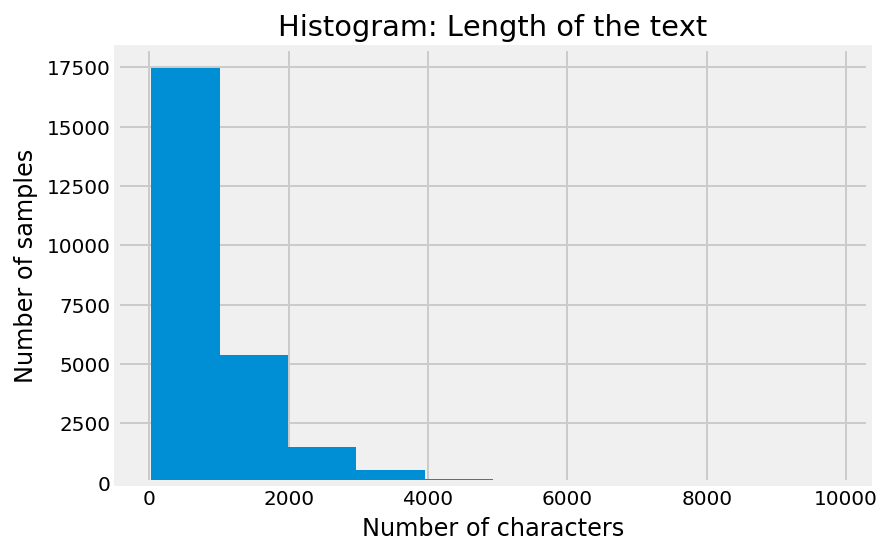

In [16]:
lens.hist()
plt.title('Histogram: Length of the text');
plt.xlabel('Number of characters')
plt.ylabel('Number of samples');

## 2.3 Average word length

In [17]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['AvgWordLength'] = data['SentimentText'].apply(lambda x: avg_word(x))
data[['SentimentText','AvgWordLength','Sentiment']].head()

,SentimentText,AvgWordLength,Sentiment
0,"first think another Disney movie, might good, ...",5.057692,1
1,"Put aside Dr. House repeat missed, Desperate H...",5.581395,0
2,"big fan Stephen King's work, film made even gr...",5.575130,1
3,watched horrid thing TV. Needless say one movi...,5.587302,0
4,truly enjoyed film. acting terrific plot. Jeff...,6.353846,1


Mean:  6.101452597803971
Std:  0.4636091889886347
Max:  9.1875


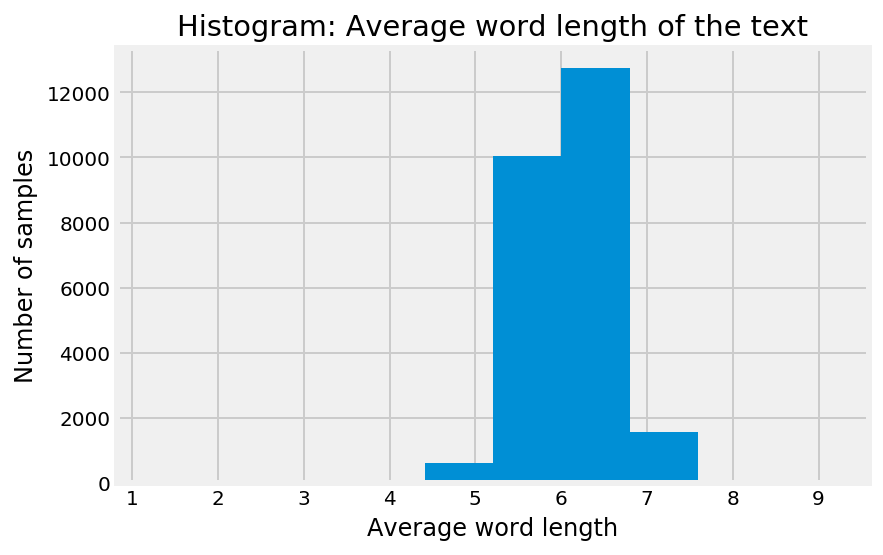

In [18]:
lens2 = data.AvgWordLength
print('Mean: ', lens2.mean())
print('Std: ', lens2.std())
print('Max: ', lens2.max())
lens2.hist()
plt.title('Histogram: Average word length of the text');
plt.xlabel('Average word length')
plt.ylabel('Number of samples');

## 2.4 Number of stopwords
Stopwords are the words which does not add much meaning to a sentence. I use stopwords from nltk.corpus library - en_core_web_sm - medium-size English language model.

In [19]:
print('Example stop words: ', stop[:10])

Example stop words:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [20]:
print('There are ', len(stop), ' stopwords defined.')

There are  179  stopwords defined.


First lower case all letters, because stopwords.words returns a list of lowercase stop words. Next calculate stopwords.

In [21]:
data['StopWordsCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.lower() in stop]))
data[['SentimentText','StopWordsCount','Sentiment']].head()

,SentimentText,StopWordsCount,Sentiment
0,"first think another Disney movie, might good, ...",1,1
1,"Put aside Dr. House repeat missed, Desperate H...",3,0
2,"big fan Stephen King's work, film made even gr...",3,1
3,watched horrid thing TV. Needless say one movi...,1,0
4,truly enjoyed film. acting terrific plot. Jeff...,2,1


Mean:  2.010600424016961
Std:  2.4099112534044407
Max:  28


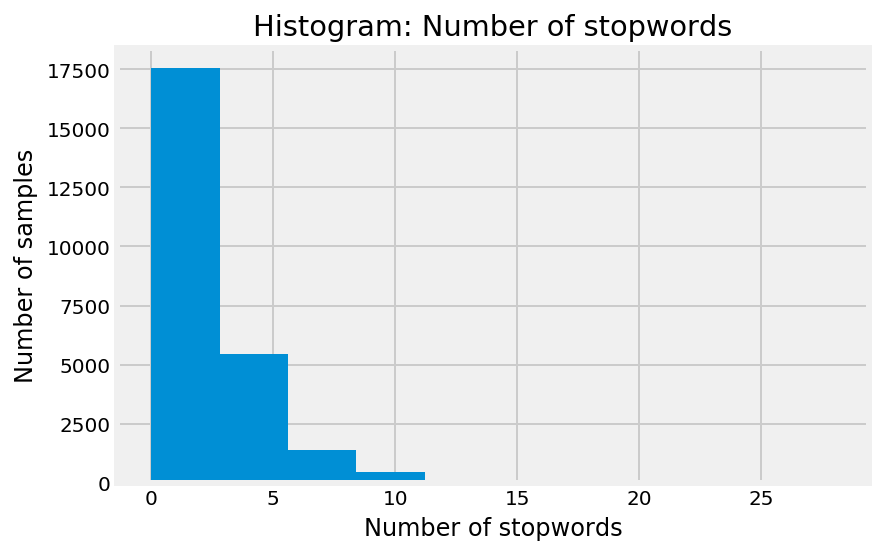

In [22]:
stopw = data.StopWordsCount
print('Mean: ', stopw.mean())
print('Std: ', stopw.std())
print('Max: ', stopw.max())
stopw.hist()
plt.title('Histogram: Number of stopwords');
plt.xlabel('Number of stopwords')
plt.ylabel('Number of samples');

## 2.5 Number of numerics

In [23]:
data['NumericsCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['SentimentText','NumericsCount','Sentiment']].head()

,SentimentText,NumericsCount,Sentiment
0,"first think another Disney movie, might good, ...",2,1
1,"Put aside Dr. House repeat missed, Desperate H...",4,0
2,"big fan Stephen King's work, film made even gr...",1,1
3,watched horrid thing TV. Needless say one movi...,0,0
4,truly enjoyed film. acting terrific plot. Jeff...,0,1


Mean:  0.5787431497259891
Std:  1.1052454432341074
Max:  22


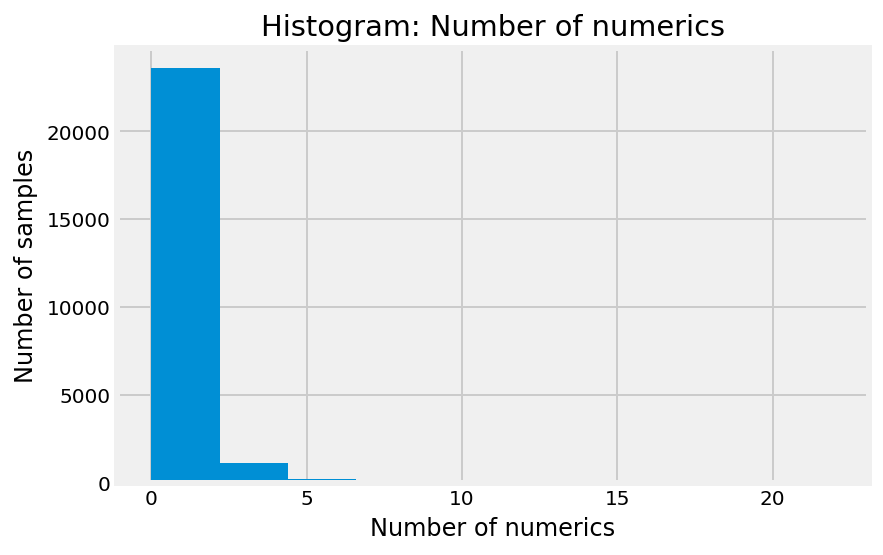

In [24]:
nums = data.NumericsCount
print('Mean: ', nums.mean())
print('Std: ', nums.std())
print('Max: ', nums.max())
nums.hist()
plt.title('Histogram: Number of numerics');
plt.xlabel('Number of numerics')
plt.ylabel('Number of samples');

## 2.6 Number of uppercase words
Anger or rage could be expressed by writing in UPPERCASE.

In [25]:
data['UppercaseCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['SentimentText','UppercaseCount','Sentiment']].head()

,SentimentText,UppercaseCount,Sentiment
0,"first think another Disney movie, might good, ...",0,1
1,"Put aside Dr. House repeat missed, Desperate H...",1,0
2,"big fan Stephen King's work, film made even gr...",0,1
3,watched horrid thing TV. Needless say one movi...,2,0
4,truly enjoyed film. acting terrific plot. Jeff...,0,1


Mean:  1.783071322852914
Std:  3.3498599308445356
Max:  108


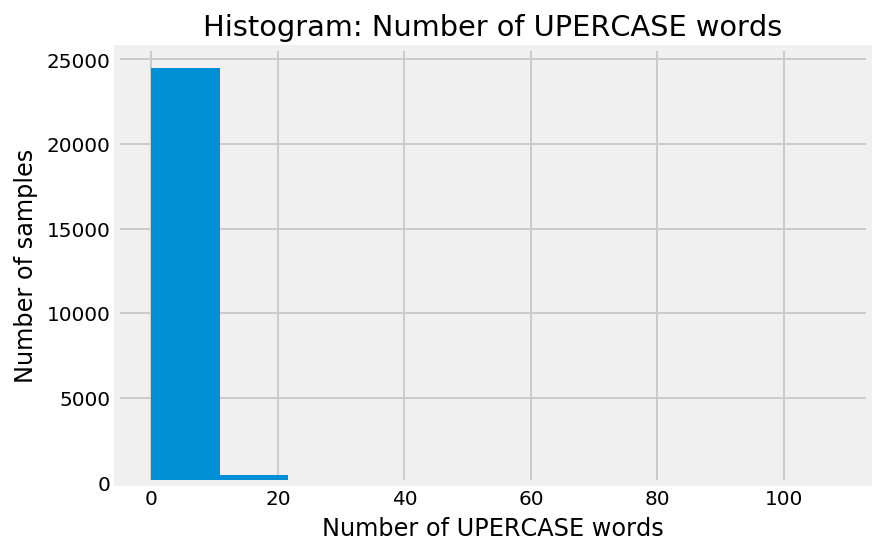

In [26]:
uppers = data.UppercaseCount
print('Mean: ', uppers.mean())
print('Std: ', uppers.std())
print('Max: ', uppers.max())
uppers.hist()
plt.title('Histogram: Number of UPERCASE words');
plt.xlabel('Number of UPERCASE words')
plt.ylabel('Number of samples');

In [27]:
print('Most UPPERCASE sentense has: ', data.loc[data['UppercaseCount'].idxmax(), 'UppercaseCount'], ' words')
print('This is the senstense: ', data.loc[data['UppercaseCount'].idxmax(), 'SentimentText'])
print('Sentiment of this sentense is: ', data.loc[data['UppercaseCount'].idxmax(), 'Sentiment'])

Most UPPERCASE sentense has:  108  words
This is the senstense:  Was'nt really bad Raw's first PPV 006. ending really really shocking everyone attendance & ones watching home.<br /><br />FIRST MATCH- RIC FLAIR VS. EDGE W/ LITA WWE INTERCONTINENTAL CHAMPIONSHIP bad opener, two seriously put great match time put wrestling match. Flair wins DQ Edge slams MITB briefcase. 3/10 SECOND MATCH- TRISH STRATUS VS. MICKIE JAMES WWE WOMEN'S CHAMPIONSHIP bad noticing fact first time Divas faced ring together. Mickie goes modified Chick Kick, Trish ducks & nails Chick Kick win retain title. 3/10 THIRD MATCH- TRIPLE H VS. BIG SHOW Seriously good match was, really. whole match HHH focuses Big Show's injured arm Big Show still fights back. Later HHH able topple Big Show & nails Pedigree win. 5/10 FOURTH MATCH- SHELTON BENJAMIN W/ MAMA VS. VISCERA {This bonus match} bad, alright. Viscera down, behind referee, Benjamin's mama got purse {Which bricks it} & slammed Viscera head three times. Viscera got get 

In that case the hipothesis is not correct.

## 2.7 Show all the properties

In [28]:
data.head(5)

,SentimentText,Sentiment,WordCount,CharCount,AvgWordLength,StopWordsCount,NumericsCount,UppercaseCount
0,"first think another Disney movie, might good, ...",1,52,263,5.057692,1,2,0
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,480,5.581395,3,4,1
2,"big fan Stephen King's work, film made even gr...",1,193,1076,5.575130,3,1,0
3,watched horrid thing TV. Needless say one movi...,0,63,352,5.587302,1,0,2
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,413,6.353846,2,0,0


# 3. Preprocessing

After processing every output goes into 'SentimentTextNew' column.

## 3.1 Lower case

In [29]:
before = data.loc[1, 'SentimentText']
data['SentimentTextNew'] = data['SentimentText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
after =  data.loc[1, 'SentimentTextNew']
print('Original data: ', before)
print('Lower case: ', after)

Original data:  Put aside Dr. House repeat missed, Desperate Housewives (new) watch one. don't know exactly plagued movie. never thought I'd say this, want 15 minutes fame back.<br /><br />Script, Direction, can't say. recognized stable actors (the usual suspects), thought Herbert Marshall class addition sat good cheesy flick. Boy, wrong. Dullsville.<br /><br />My favorite parts: "office girl" makes 029 keypunch puts cards 087 sorter. LOL @ "the computer". I'd like someone identify next device - 477 ? It's even dinosaur's time.<br /><br />And dinosaurs don't much time waste.
Lower case:  put aside dr. house repeat missed, desperate housewives (new) watch one. don't know exactly plagued movie. never thought i'd say this, want 15 minutes fame back.<br /><br />script, direction, can't say. recognized stable actors (the usual suspects), thought herbert marshall class addition sat good cheesy flick. boy, wrong. dullsville.<br /><br />my favorite parts: "office girl" makes 029 keypunch puts 

## 3.2 Remove URLs

In [30]:
before = data.loc[542, 'SentimentTextNew']
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: re.sub(r'(?:\@|https?\://)\S+', '', x))
after =  data.loc[542, 'SentimentTextNew']
print('Original data: ', before)
print('Lower case: ', after)

Original data:  63 year reign queen victoria perhaps one documented popularly known historical reigns british history. one hand, story lacks theatrics earlier royals thanks change social climate attitudes, story one perpetuates notably human. taking earlier years life budding romance german prince albert taking forefront, director jean-marc vallã©e recently remained unbeknownst shadows industry takes victoria's story captures human element vital legacy. it's story feels extremely humble considering exuberant background, yet that's partly gives distinct edge separates usual fare.<br /><br />taking direct focused approach centres brief five year period ascension marriage albert, young victoria little period pieces nature offer. instead attempting sprawling encapsulation figure's entire life, vallã©e instead opts show one lesser known intricacies victoria's early years easily overlooked favour publicly known accolades. result feature may disgruntle historians thanks relatively flippant re

## 3.3 Remove html tags

In [31]:
before = data.loc[10, 'SentimentTextNew']
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: re.sub(r'<[^>]+>', '', x))
after =  data.loc[10, 'SentimentTextNew']
print('Original data: ', before)
print('Lower case: ', after)

Original data:  strange sex comedy there`s little comedy whole lot sex , takes place back car graphic makes basic instinct look like edition teletubbies . kid , sex film face might choke , especially you`re watching grandparents .<br /><br />as rest rita , sue bob there`s much else worth mentioning except language every single sentence seems contain f word . rather bleak hyper-realist british film made time channel 4 main investor british movies explains made television low budget feel
Lower case:  strange sex comedy there`s little comedy whole lot sex , takes place back car graphic makes basic instinct look like edition teletubbies . kid , sex film face might choke , especially you`re watching grandparents .as rest rita , sue bob there`s much else worth mentioning except language every single sentence seems contain f word . rather bleak hyper-realist british film made time channel 4 main investor british movies explains made television low budget feel


## 3.4 Remove non-letters and non-digits characters

In [32]:
before = data.loc[1, 'SentimentTextNew']
data['SentimentTextNew'] = data['SentimentTextNew'].str.replace('[^\w\s]','')
after =  data.loc[1, 'SentimentTextNew']
print('Original data: ', before)
print('Lower case: ', after)

Original data:  put aside dr. house repeat missed, desperate housewives (new) watch one. don't know exactly plagued movie. never thought i'd say this, want 15 minutes fame back.script, direction, can't say. recognized stable actors (the usual suspects), thought herbert marshall class addition sat good cheesy flick. boy, wrong. dullsville.my favorite parts: "office girl" makes 029 keypunch puts cards 087 sorter. lol @ "the computer". i'd like someone identify next device - 477 ? it's even dinosaur's time.and dinosaurs don't much time waste.
Lower case:  put aside dr house repeat missed desperate housewives new watch one dont know exactly plagued movie never thought id say this want 15 minutes fame backscript direction cant say recognized stable actors the usual suspects thought herbert marshall class addition sat good cheesy flick boy wrong dullsvillemy favorite parts office girl makes 029 keypunch puts cards 087 sorter lol  the computer id like someone identify next device  477  its ev

## 3.5 Remove stop words

In [33]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## 3.6 Lemmatization using spaCy
Convert the word into its root word.

Warning: Time consuming operation!

In [34]:
before = data.loc[68, 'SentimentTextNew']
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(word.lemma_ for word in sp(x)))

Get sample text and compare results.

In [35]:
print('Before: ', before)
after = data.loc[68, 'SentimentTextNew']
print('After: ', after)

Before:  boring badly written italian exploitation flicklots nudity gore awful actingthe werewolf makeup thing would raise laughcomplete rubbisheven fans cheesy italian horrorplease avoid
After:  bore badly write italian exploitation flicklot nudity gore awful actingthe werewolf makeup thing would raise laughcomplete rubbisheven fan cheesy italian horrorplease avoid


## 3.7 Part-of-speech tags and dependencies
Assign a category tag to the tokenized parts of a sentence.
* Text: The original word text.
* Lemma: The base form of the word.
* POS: The simple part-of-speech tag.
* Tag: The detailed part-of-speech tag.
* Dep: Syntactic dependency, i.e. the relation between tokens.
* Shape: The word shape – capitalization, punctuation, digits.
* is alpha: Is the token an alpha character?
* is stop: Is the token part of a stop list, i.e. the most common words of the language?

In [36]:
doc = sp(after)
labs = ['TEXT',	'LEMMA', 'POS',	'TAG',	'DEP',	'SHAPE',	'IS ALPHA',	'IS STOP']
df = pd.DataFrame([], columns=labs)

text = []
lemma = []
pos = []
tag = []
dep = []
shape = []
is_alpha = []
is_stop = [] 

for token in doc:
  text.append(token.text)
  lemma.append(token.lemma_)
  pos.append(token.pos_)
  tag.append(token.tag_)
  dep.append(token.dep_)
  shape.append(token.shape_)
  is_alpha.append(token.is_alpha)
  is_stop.append(token.is_stop)

df['TEXT'] = text
df['LEMMA'] = lemma
df['POS'] = pos
df['TAG'] = tag
df['DEP'] = dep
df['SHAPE'] = shape
df['IS ALPHA'] = is_alpha
df['IS STOP'] = is_stop
df

,TEXT,LEMMA,POS,TAG,DEP,SHAPE,IS ALPHA,IS STOP
0,bore,bore,PROPN,NNP,nsubj,xxxx,True,False
1,badly,badly,ADV,RB,advmod,xxxx,True,False
2,write,write,VERB,VB,ROOT,xxxx,True,False
3,italian,italian,ADJ,JJ,amod,xxxx,True,False
4,exploitation,exploitation,NOUN,NN,compound,xxxx,True,False
5,flicklot,flicklot,PART,POS,compound,xxxx,True,False
6,nudity,nudity,NOUN,NN,compound,xxxx,True,False
7,gore,gore,PROPN,NNP,dobj,xxxx,True,False
8,awful,awful,PROPN,NNP,amod,xxxx,True,False
9,actingthe,actingthe,PROPN,NNP,det,xxxx,True,False


## 3.8 Named Entities
“Real-world object” that’s assigned a name

In [37]:
test = random.sample(data['SentimentTextNew'].values.tolist(), 1)
doc2 = sp(str(test))
displacy.render(doc2, style = "ent",jupyter = True)

## 3.9 Dependency Parsing
* Determine the meaning of a sentence by analyzing how it’s constructed 
* Determine how the individual words relate to each other

In [38]:
displacy.render(sp(after), style="dep", jupyter= True)

## 3.10 Bag of words
Maximum of 10000 features.

In [39]:
count = CountVectorizer(max_features = 10000)
bag_of_words = count.fit_transform(data.SentimentTextNew.to_numpy())
feature_names = count.get_feature_names()
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
bow_df.head()

,010,10,100,1000,10000,101,1010,11,110,11th,...,zodiac,zoe,zombi,zombie,zombies,zone,zoo,zoom,zorro,zu
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.11 Common words

### 3.11.1 Count common words occurrence frequency



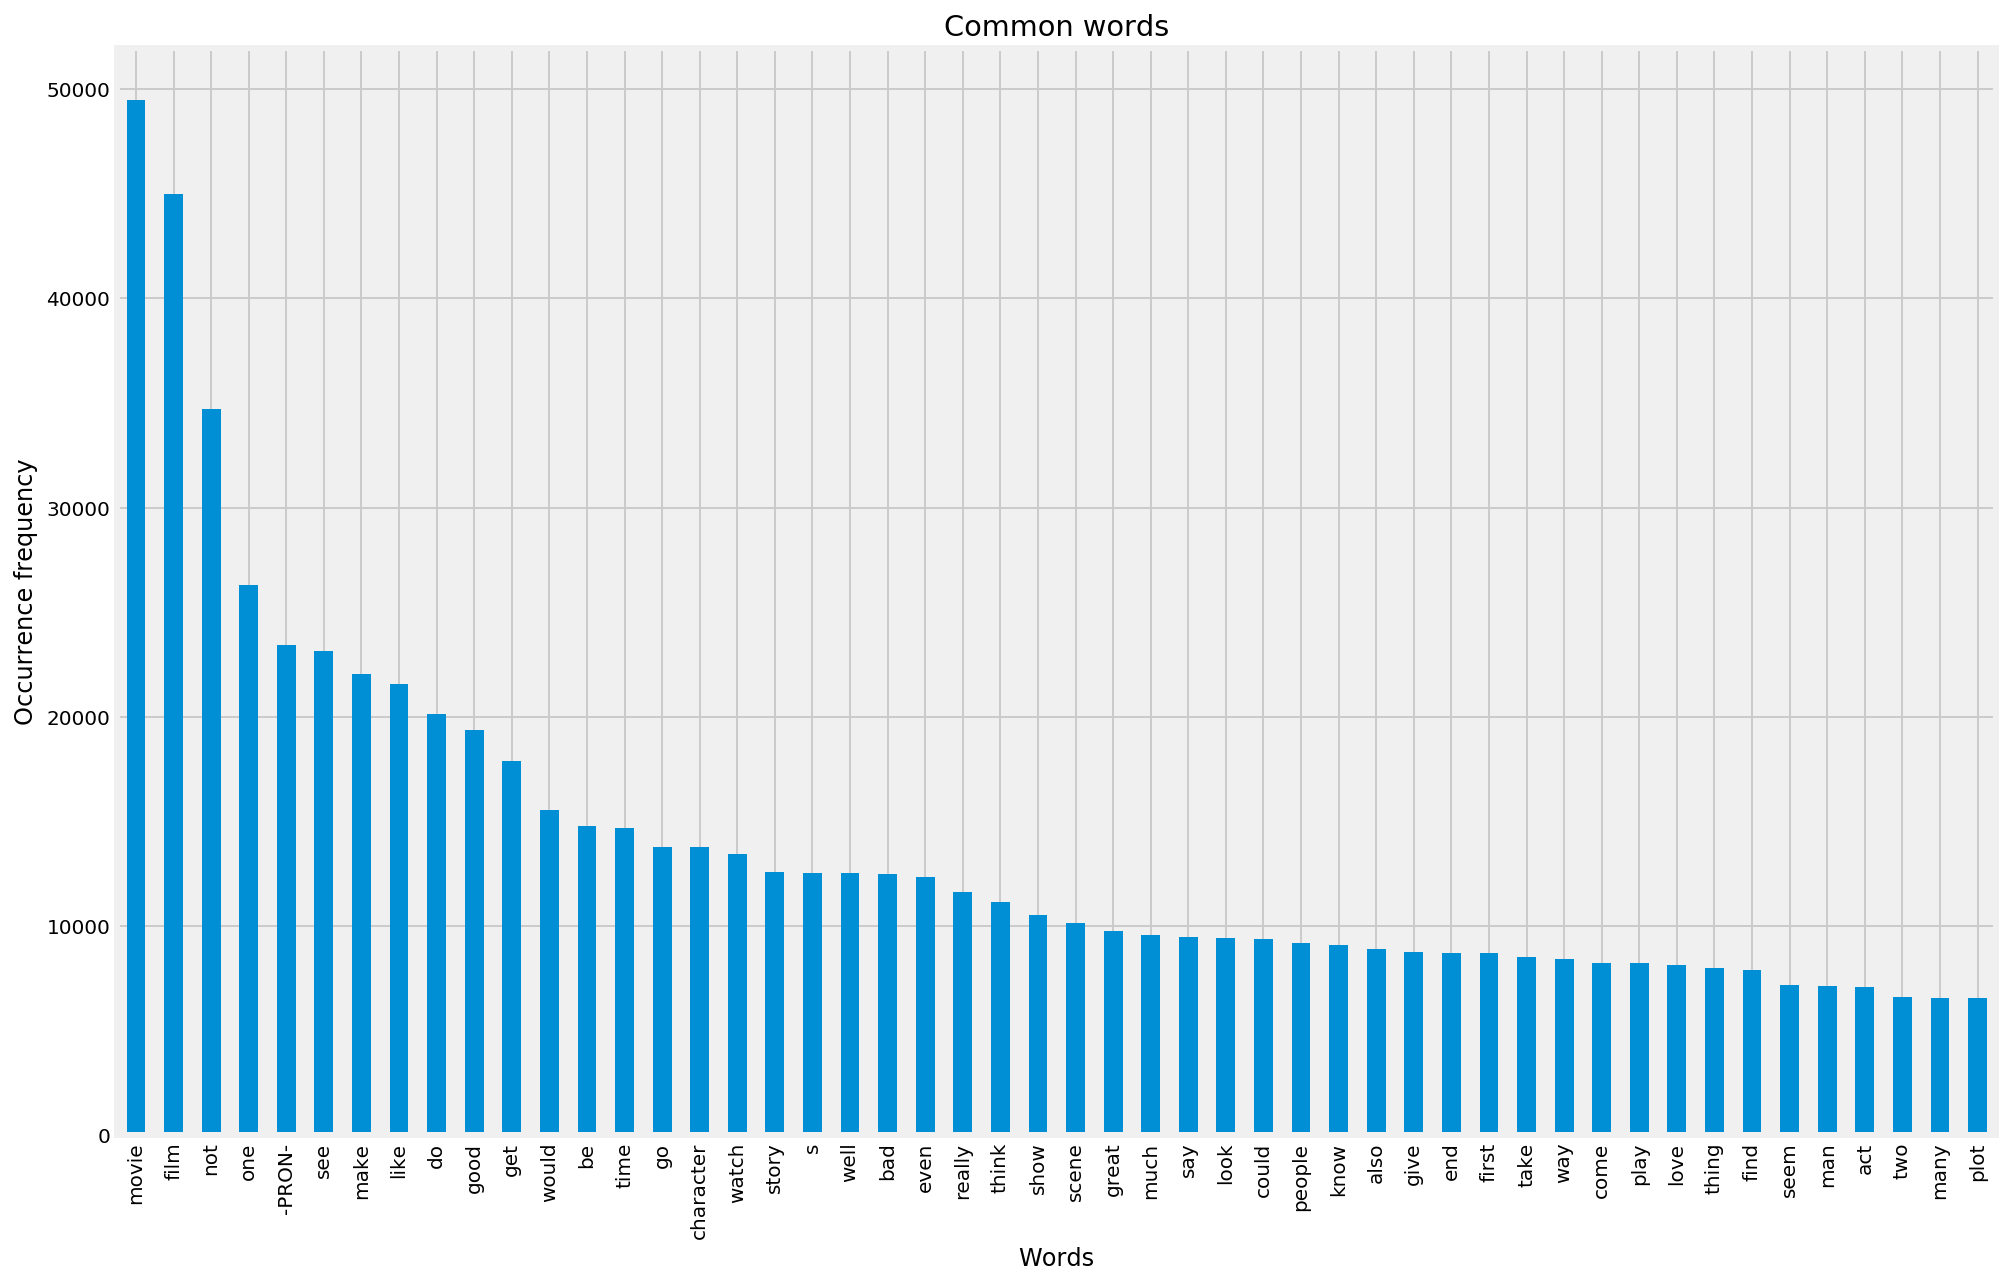

In [40]:
freq_common = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
plt.figure(figsize=(15,10))
freq_common[:50].plot.bar()
plt.xlabel('Words')
plt.ylabel('Occurrence frequency')
plt.title('Common words');

### 3.11.2 Remove common words
Remove the first 11 words.

In [41]:
freq_common_10 = list(freq_common[:11].index)
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_common_10))

Check the results.

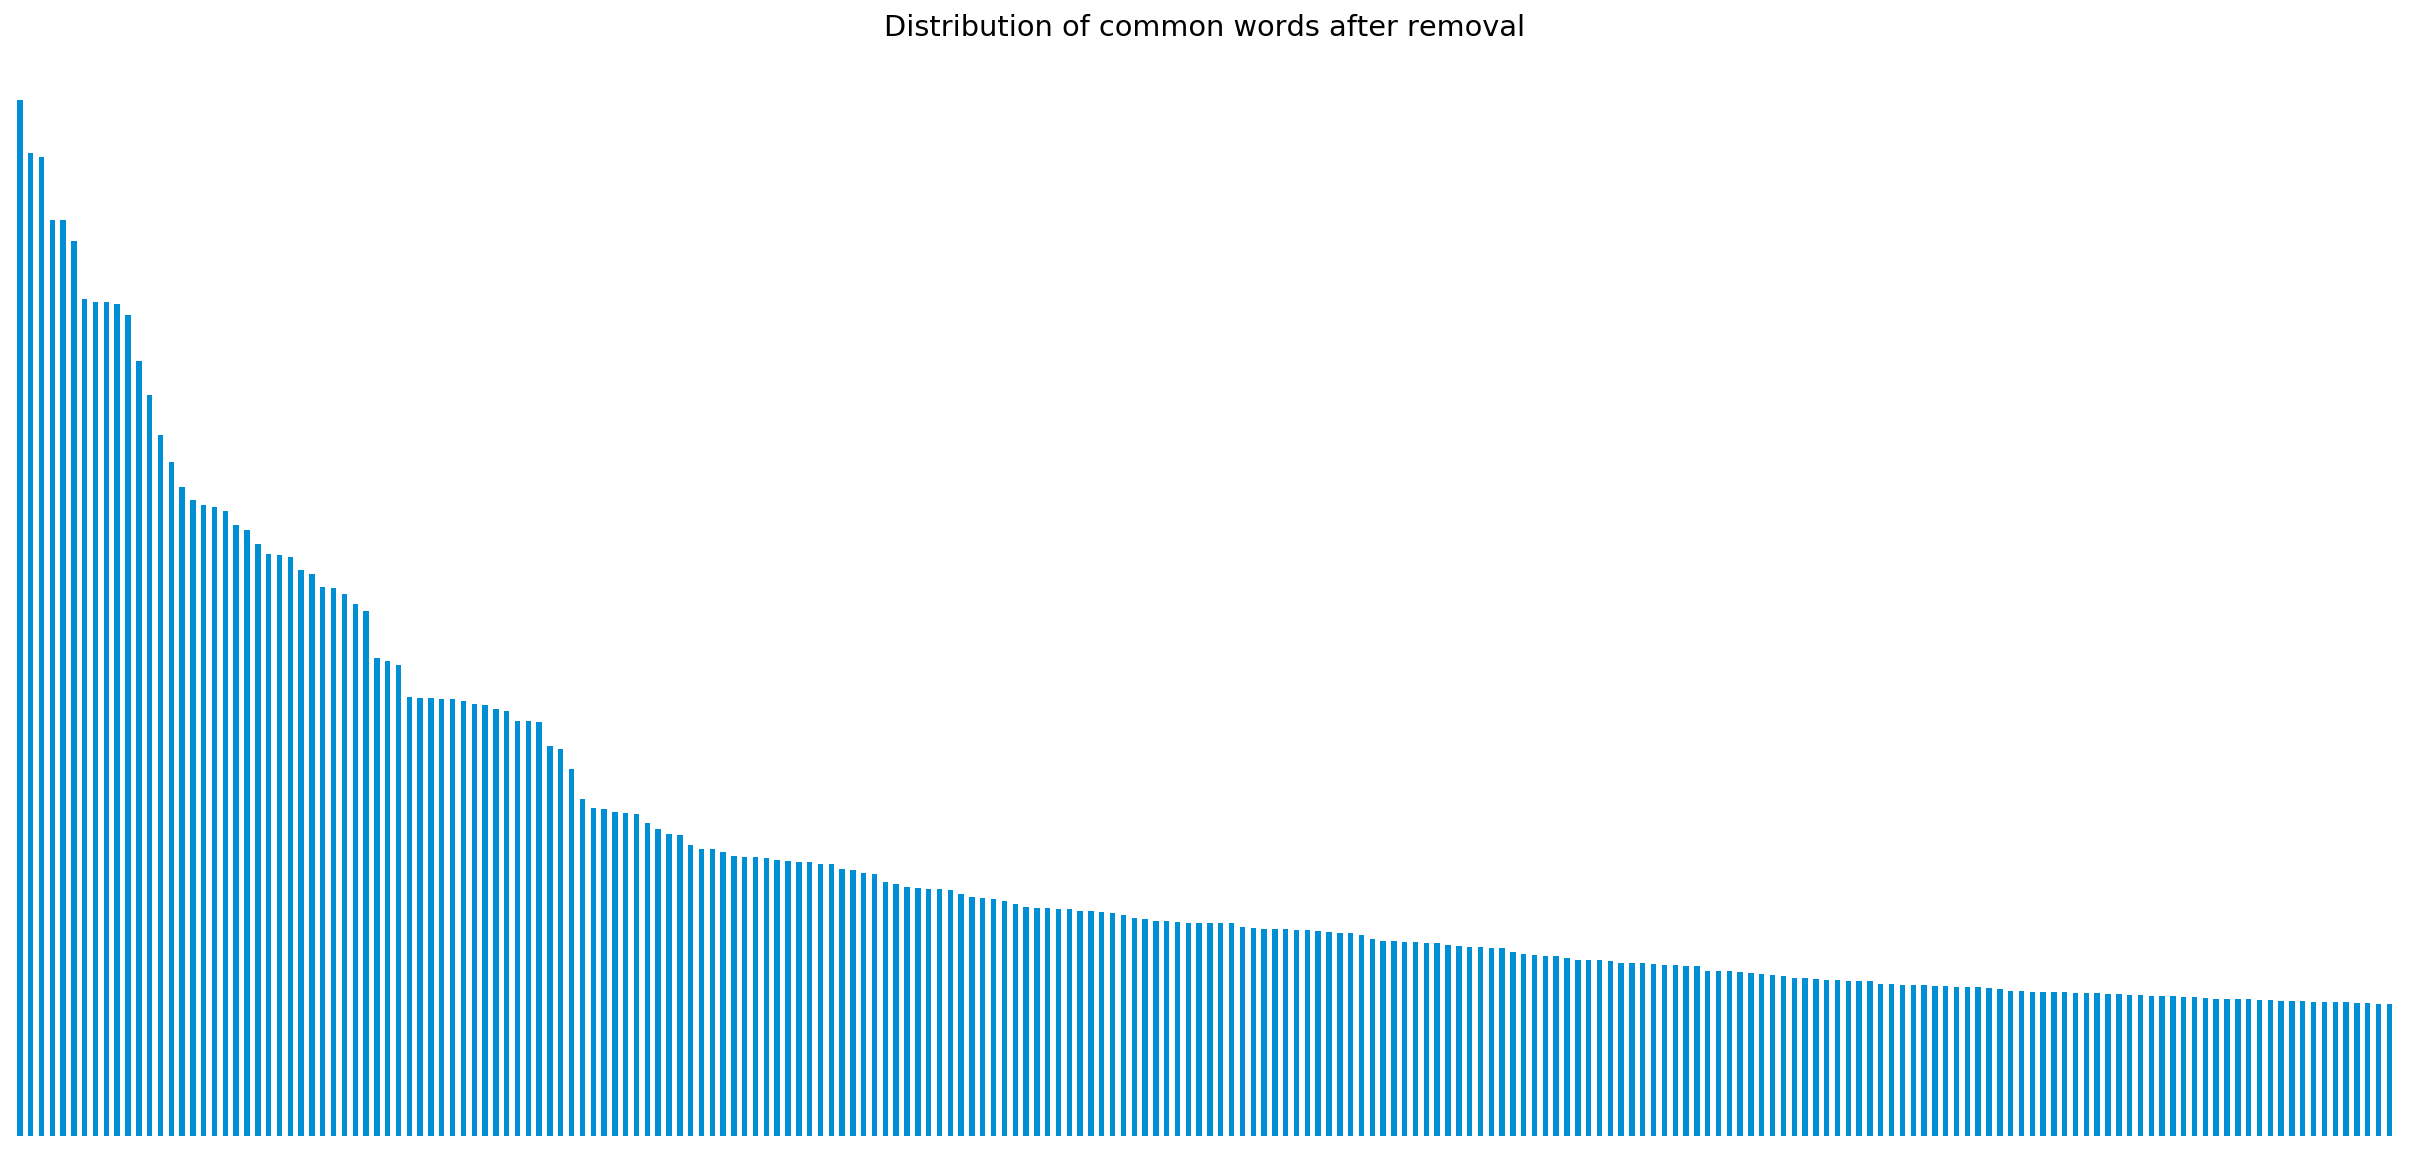

In [42]:
freq_common_new = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
plt.figure(figsize=(19,10))
freq_common_new[:220].plot.bar()
plt.title('Distribution of common words after removal');
plt.axis("off");

## 3.12 Rare words

### 3.12.1 Count rare words occurrence frequency

In [43]:
freq_rare = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
freq_rare

would        15556
be           14756
time         14699
go           13757
character    13750
             ...  
balearic         1
fastworke        1
goalsbe          1
electrics        1
filmlook         1
Length: 132412, dtype: int64

Get the words with only one occurence.

In [44]:
one_occurence = freq_rare[freq_rare==1]
one_occurence

sunkthe        1
plume          1
reasonsjena    1
enddidnt       1
stupidness     1
              ..
balearic       1
fastworke      1
goalsbe        1
electrics      1
filmlook       1
Length: 83362, dtype: int64

In [45]:
len(one_occurence)

83362

## 3.13 Word cloud

### 3.13.1 Word cloud of negative terms

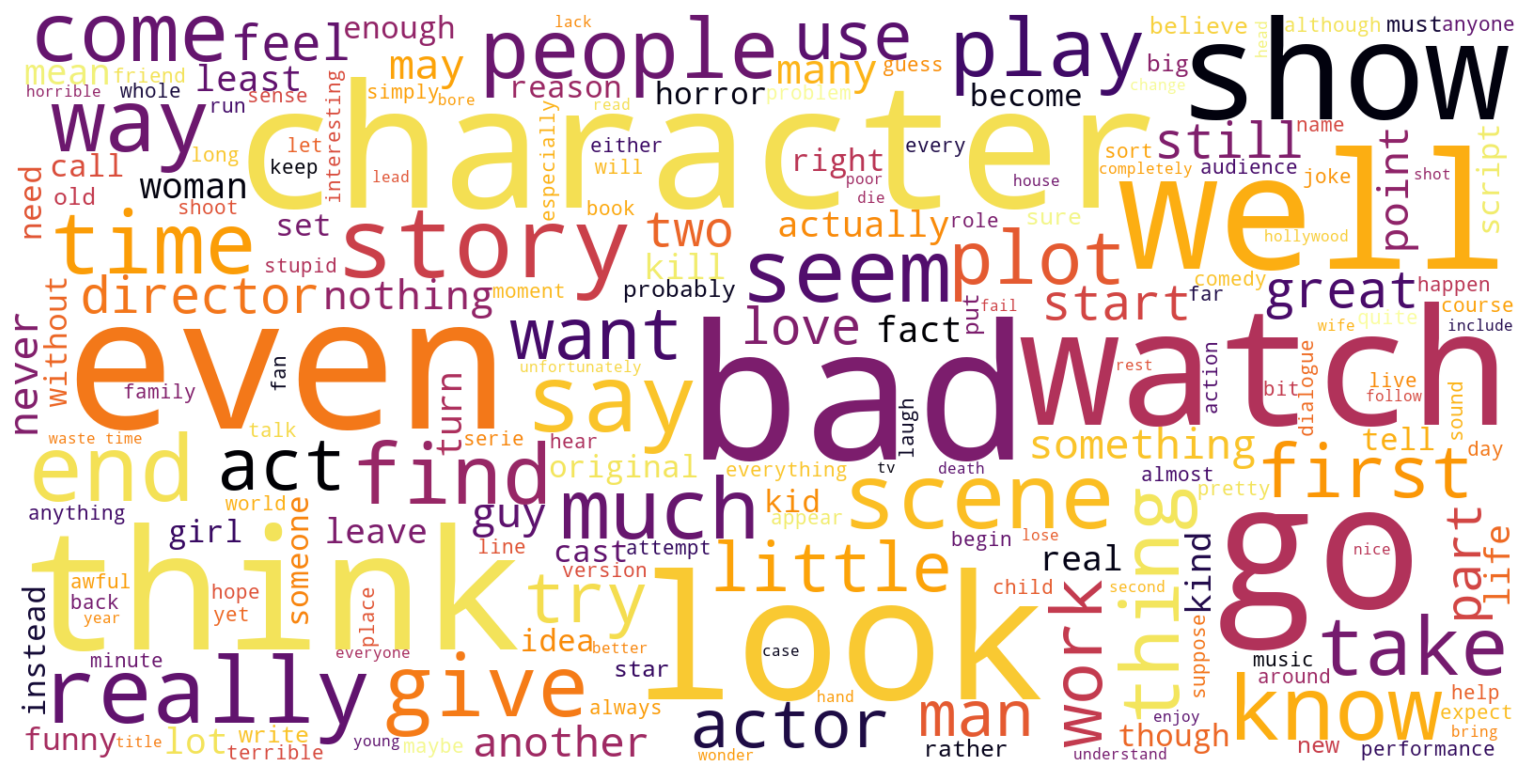

In [46]:
neg_tweets = data[data.Sentiment == 0]
neg_string = []

for t in neg_tweets.SentimentTextNew:
    neg_string.append(t)

neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='inferno',
    background_color='white').generate(neg_string)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.13.2 Word cloud of positive terms

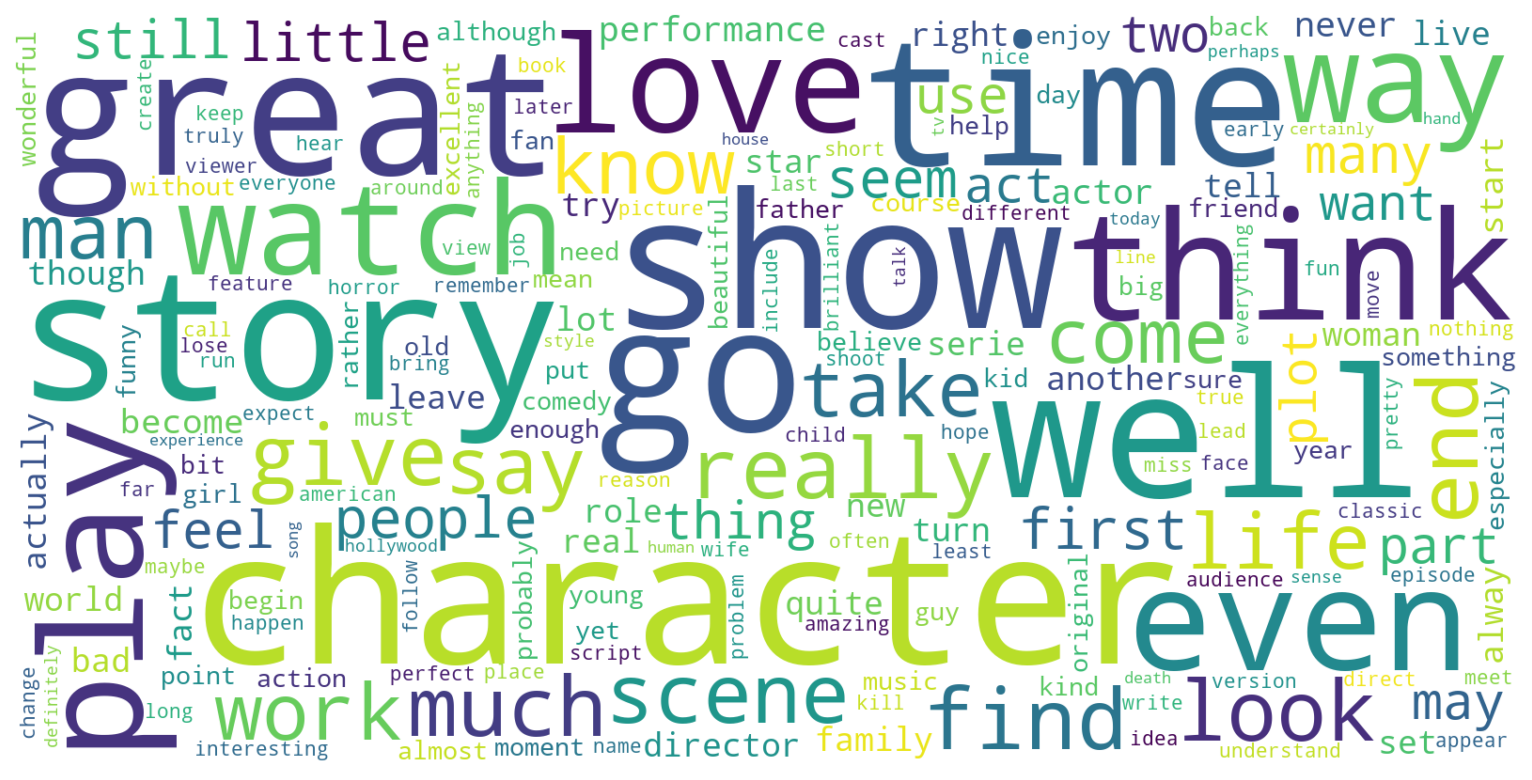

In [47]:
pos_tweets = data[data.Sentiment == 1]
pos_string = []

for t in pos_tweets.SentimentTextNew:
    pos_string.append(t)

pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='viridis',
    background_color='white').generate(pos_string) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

# 4. Classification

## 4.1 Split into train and test
Assumption:
- 20% Test
- 80% Train

In [48]:
SEED = 1234
x_train, x_validation, y_train, y_validation = train_test_split(data.SentimentTextNew, data.Sentiment, test_size=.2, random_state=SEED)

## 4.2 Compare classifiers
Classifiers:
- Logistic Regression
- Multinomial NB
- Perceptron

In [49]:
names = ["Logistic Regression", "Multinomial NB", "Perceptron"]
classifiers = [LogisticRegression(), MultinomialNB(), Perceptron()]
zipped_clf = zip(names,classifiers)

Use tfidf to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [50]:
vec = TfidfVectorizer()

Functions to compare classifiers. In addition use n-gram - a contiguous sequence of n items from a given sample, in range of 1,3 as parameter.

In [51]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr


def classifier_comparator(vectorizer=vec, n_features=10000, ngram_range=(1, 3), classifier=zipped_clf):
    result = []
    vectorizer.set_params(max_features=n_features, ngram_range=ngram_range)

    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))

    return result


result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression


C:\Users\rafal_000\Anaconda3\envs\RafalEnv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average precision-recall score: 0.84
accuracy score: 88.26%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
Average precision-recall score: 0.84
accuracy score: 87.68%
--------------------------------------------------------------------------------
Validation result for Perceptron
Average precision-recall score: 0.84
accuracy score: 87.34%
--------------------------------------------------------------------------------


Warning: Plots doesn't render correctly in Colab!

In [53]:
acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)


data2 = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data2, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [54]:
data3 = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data3.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data3, layout=layout)
py.iplot(fig)